<a href="https://colab.research.google.com/github/bharathulaprasad/Assignment_06/blob/main/BreastCancerData_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
from sklearn.model_selection import train_test_split
!pip install pydataset
!pip install sns
from pydataset import data
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cancerdata = load_breast_cancer()
print(cancerdata.DESCR)





  Created wheel for sns: filename=sns-0.1-cp37-none-any.whl size=2664 sha256=49a00ca0fb6e52a03db843497bdf369e7d7f6f1c4ede1df49f394163c15db349
  Stored in directory: /root/.cache/pip/wheels/be/a5/d8/4390400ed430c8186a6af96dbb1cc7d0a00a5dee15d268b627
Successfully built sns
.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - f

In [ ]:
can = pd.DataFrame(cancerdata.data,columns=cancerdata.feature_names)
can['diagnosis'] = cancerdata.target
can = pd.DataFrame(cancerdata.data,cancerdata.target)
can.isnull().sum().sum()
# This indicates no data cleaning required


0

In [ ]:
# estimate how many are 0 and 1 is present in target diagnosis
pd.crosstab(index = cancerdata.target, columns = 'count')

col_0,count
row_0,
0,212
1,357


In [ ]:
can.describe().unstack()

0   count    569.000000
    mean      14.127292
    std        3.524049
    min        6.981000
    25%       11.700000
                ...    
29  min        0.055040
    25%        0.071460
    50%        0.080040
    75%        0.092080
    max        0.207500
Length: 240, dtype: float64

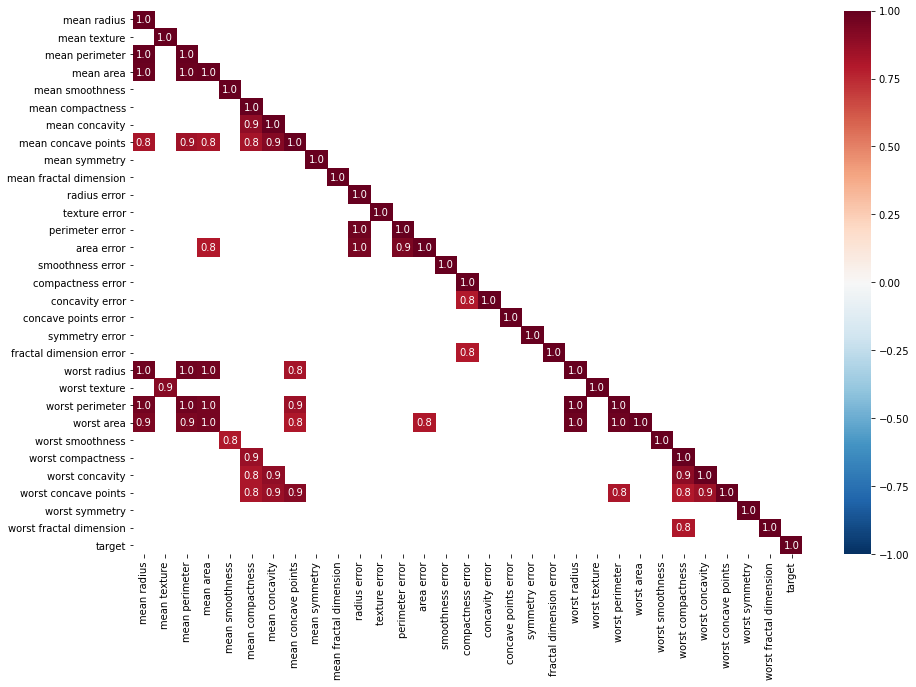

In [24]:
# Create correlation matrix

!pip install seaborn
import seaborn as sns
df_features = pd.DataFrame(cancerdata.data, columns = cancerdata.feature_names)
df_target = pd.DataFrame(cancerdata.target, columns=['target'])

df = pd.concat([df_features, df_target], axis=1)
corr_mat = df.corr()

# Create mask
mask = np.zeros_like(corr_mat, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat[corr_mat > 0.8], annot=True, fmt='.1f',
            cmap='RdBu_r', vmin=-1, vmax=1,
            mask=mask)

In [ ]:
##I will use Univariate Feature Selection (sklearn.feature_selection.SelectKBest) 
##to choose 5 features with the k highest scores. 
##I choose 5 because from the heatmap I could see about 5 groups of features that are highly correlated.
from sklearn.feature_selection import SelectKBest, chi2
feature_selection = SelectKBest(chi2, k=5)
feature_selection.fit(df_features, df_target)
selected_features = df_features.columns[feature_selection.get_support()]
print("The five selected features are: ", list(selected_features))

The five selected features are:  ['mean perimeter', 'mean area', 'area error', 'worst perimeter', 'worst area']


In [ ]:
X = pd.DataFrame(feature_selection.transform(df_features),
                 columns=selected_features)
X.head()

In [ ]:
can = pd.DataFrame(cancerdata.data,columns=cancerdata.feature_names)
can['diagnosis'] = cancerdata.target
can.sample(5)

In [ ]:
sns.pairplot(pd.concat([X, df['target']], axis=1), hue='target')

In [ ]:
from sklearn.model_selection import train_test_split
y = df_target['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.10,test_size=0.90, random_state=42)

In [ ]:
#Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
#Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
#PCA analysis to analyse distribution of the features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_features)

features_scaled = scaler.transform(df_features)

features_scaled = pd.DataFrame(data=features_scaled,
                               columns=df_features.columns)
features_scaled.head(5)
df_scaled = pd.concat([features_scaled, df['target']], axis=1)
X_scaled = features_scaled
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
plt.figure(figsize=(8, 8))
sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=df['target'])
plt.title("PCA")
plt.xlabel("First Principal Component")
plt.xlabel("Second Principal Component")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, stratify=cancerdata.target, train_size=0.10, test_size=0.90, random_state=42)
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train, y_train)
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_test,y_test)))


In [ ]:
#drawing the graph
training_accuracy = []
test_accuracy = []

#try log_reg for diffrent k nearest neighbor from 1 to 15
neighbors_setting = range(1,15)

for n_neighbors in neighbors_setting:
    log_reg = LogisticRegression(max_iter=100000)
    log_reg.fit(X_train,y_train)
    training_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))
 
plt.plot(neighbors_setting,training_accuracy, label='Accuracy of the training set')
plt.plot(neighbors_setting,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, stratify=cancerdata.target, train_size=0.20, test_size=0.80, random_state=42)
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train, y_train)
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_test,y_test)))
training_accuracy = []
test_accuracy = []

#try log_reg for diffrent k nearest neighbor from 1 to 15
neighbors_setting = range(1,15)

for n_neighbors in neighbors_setting:
    log_reg = LogisticRegression(max_iter=100000)
    log_reg.fit(X_train,y_train)
    training_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))
 
plt.plot(neighbors_setting,training_accuracy, label='Accuracy of the training set')
plt.plot(neighbors_setting,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, stratify=cancerdata.target, train_size=0.30, test_size=0.70, random_state=42)
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train, y_train)
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_test,y_test)))
training_accuracy = []
test_accuracy = []

#try log_reg for diffrent k nearest neighbor from 1 to 15
neighbors_setting = range(1,15)

for n_neighbors in neighbors_setting:
    log_reg = LogisticRegression(max_iter=100000)
    log_reg.fit(X_train,y_train)
    training_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))
 
plt.plot(neighbors_setting,training_accuracy, label='Accuracy of the training set')
plt.plot(neighbors_setting,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, stratify=cancerdata.target, train_size=0.40, test_size=0.60, random_state=42)
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train, y_train)
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_test,y_test)))
training_accuracy = []
test_accuracy = []

#try log_reg for diffrent k nearest neighbor from 1 to 15
neighbors_setting = range(1,15)

for n_neighbors in neighbors_setting:
    log_reg = LogisticRegression(max_iter=100000)
    log_reg.fit(X_train,y_train)
    training_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))
 
plt.plot(neighbors_setting,training_accuracy, label='Accuracy of the training set')
plt.plot(neighbors_setting,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, stratify=cancerdata.target, train_size=0.50, test_size=0.50, random_state=42)
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train, y_train)
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_test,y_test)))
training_accuracy = []
test_accuracy = []

#try log_reg for diffrent k nearest neighbor from 1 to 15
neighbors_setting = range(1,15)

for n_neighbors in neighbors_setting:
    log_reg = LogisticRegression(max_iter=100000)
    log_reg.fit(X_train,y_train)
    training_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))
 
plt.plot(neighbors_setting,training_accuracy, label='Accuracy of the training set')
plt.plot(neighbors_setting,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, stratify=cancerdata.target, train_size=0.60, test_size=0.40, random_state=42)
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train, y_train)
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_test,y_test)))
training_accuracy = []
test_accuracy = []

#try log_reg for diffrent k nearest neighbor from 1 to 15
neighbors_setting = range(1,15)

for n_neighbors in neighbors_setting:
    log_reg = LogisticRegression(max_iter=100000)
    log_reg.fit(X_train,y_train)
    training_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))
 
plt.plot(neighbors_setting,training_accuracy, label='Accuracy of the training set')
plt.plot(neighbors_setting,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()

In [ ]:
#Feature importance
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, random_state=0)

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train,y_train)

n_feature = cancerdata.data.shape[1]
plt.barh(range(n_feature), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_feature), cancerdata.feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
#----------------- Decision Tree
from sklearn.tree import DecisionTreeClassifier        #Decision Tree
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, random_state=42)

training_accuracy = []
test_accuracy = []

max_dep = range(1,15)

for md in max_dep:
    tree = DecisionTreeClassifier(max_depth=md,random_state=0)
    tree.fit(X_train,y_train)
    training_accuracy.append(tree.score(X_train, y_train))
    test_accuracy.append(tree.score(X_test, y_test))
 
plt.plot(max_dep,training_accuracy, label='Accuracy of the training set')
plt.plot(neighbors_setting,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.legend()